In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import os 
import gc

from sklearn import set_config
from sklearn.base import clone 
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set_theme(palette = 'viridis')
pal = sns.color_palette('viridis')

set_config(transform_output = 'pandas')

In [6]:
# Lowering memory usage 

dtypes = {
    'stock_id' : np.uint8,
    'date_id' : np.uint16,
    'seconds_in_bucket' : np.uint16,
    'imbalance_buy_sell_flag' : np.int8,
    'time_id' : np.uint16,
}

train = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv", dtype = dtypes).drop(['row_id', 'time_id'], axis = 1)
test = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv", dtype = dtypes).drop(['row_id','time_id'], axis = 1)

gc.collect()

60809

#### Descriptive Stats

In [7]:
train.head(15)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333


In [8]:
desc = pd.DataFrame(index = list(train))
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['type'] = train.dtypes
desc = pd.concat([desc, train.describe().T], axis = 1)
desc

,count,nunique,%unique,null,type,count,mean,std,min,25%,50%,75%,max
stock_id,5237980,200,0.003818,0,uint8,5237980.0,9.928856e+01,5.787176e+01,0.000000,4.900000e+01,9.900000e+01,1.490000e+02,1.990000e+02
date_id,5237980,481,0.009183,0,uint16,5237980.0,2.415100e+02,1.385319e+02,0.000000,1.220000e+02,2.420000e+02,3.610000e+02,4.800000e+02
seconds_in_bucket,5237980,55,0.001050,0,uint16,5237980.0,2.700000e+02,1.587451e+02,0.000000,1.300000e+02,2.700000e+02,4.100000e+02,5.400000e+02
imbalance_size,5237760,2971863,56.736815,220,float64,5237760.0,5.715293e+06,2.051591e+07,0.000000,8.453415e+04,1.113604e+06,4.190951e+06,2.982028e+09
imbalance_buy_sell_flag,5237980,3,0.000057,0,int8,5237980.0,-1.189619e-02,8.853374e-01,-1.000000,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
reference_price,5237760,28741,0.548704,220,float64,5237760.0,9.999955e-01,2.532497e-03,0.935285,9.987630e-01,9.999670e-01,1.001174e+00,1.077488e+00
matched_size,5237760,2948862,56.297695,220,float64,5237760.0,4.510025e+07,1.398413e+08,4316.610000,5.279575e+06,1.288264e+07,3.270013e+07,7.713682e+09
far_price,2343638,95739,1.827785,2894342,float64,2343638.0,1.001713e+00,7.214705e-01,0.000077,9.963320e-01,9.998830e-01,1.003318e+00,4.379531e+02
near_price,2380800,84625,1.615604,2857180,float64,2380800.0,9.996601e-01,1.216920e-02,0.786988,9.971000e-01,9.998890e-01,1.002590e+00,1.309732e+00
bid_price,5237760,28313,0.540533,220,float64,5237760.0,9.997263e-01,2.499345e-03,0.934915,9.985290e-01,9.997280e-01,1.000905e+00,1.077488e+00


5.2379 million rows in the train dataset. Some features are missing almost half of the rows. 88 rows missing the target.

In [9]:
test.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0
5,5,478,0,1150507.59,-1,0.999867,1580452.21,NaN,NaN,0.999722,10312.50,1.000449,16649.60,1.0
6,6,478,0,57213.11,1,1.000361,3424296.94,NaN,NaN,0.999765,5535.45,1.000361,8492.75,1.0
7,7,478,0,14786077.01,1,0.998998,54031419.37,NaN,NaN,0.998686,79933.75,1.000263,16012.00,1.0
8,8,478,0,26157362.75,-1,0.999809,24384072.48,NaN,NaN,0.998885,10638.52,1.000279,2663.34,1.0
9,9,478,0,426671.05,-1,1.000084,4467248.15,NaN,NaN,0.999952,755.00,1.000482,7554.00,1.0


In [11]:
temporal_features = ['date_id', 'seconds_in_bucket']
categorical_features = ['imbalance_buy_sell_flag', 'stock_id']
numerical_features = test.drop(temporal_features + categorical_features, axis = 1).columns

#### Distribution of Numerical Feature

In [13]:
fig, axs = plt.subplots(5,2, figsize = (15, 20), dpi = 600)
axs = axs.flatten()

for i, col in enumerate(numerical_features):
    
    sns.kdeplot(train[col], ax = axs[i], color = pal[0], fill = True)
    
    axs[i].set_title(f"{col} Distribution", size = 14)
    axs[i].set_xlabel(None)
    
fig.suptitle("Distribution of Numerical Features \n per Dataset \n", fontsize = 32, fontweight = 'bold')
plt.tight_layout()

#### Distribbution of Categorical Features 
Categorical Features: `checking imbalance_buy_sell_flag`

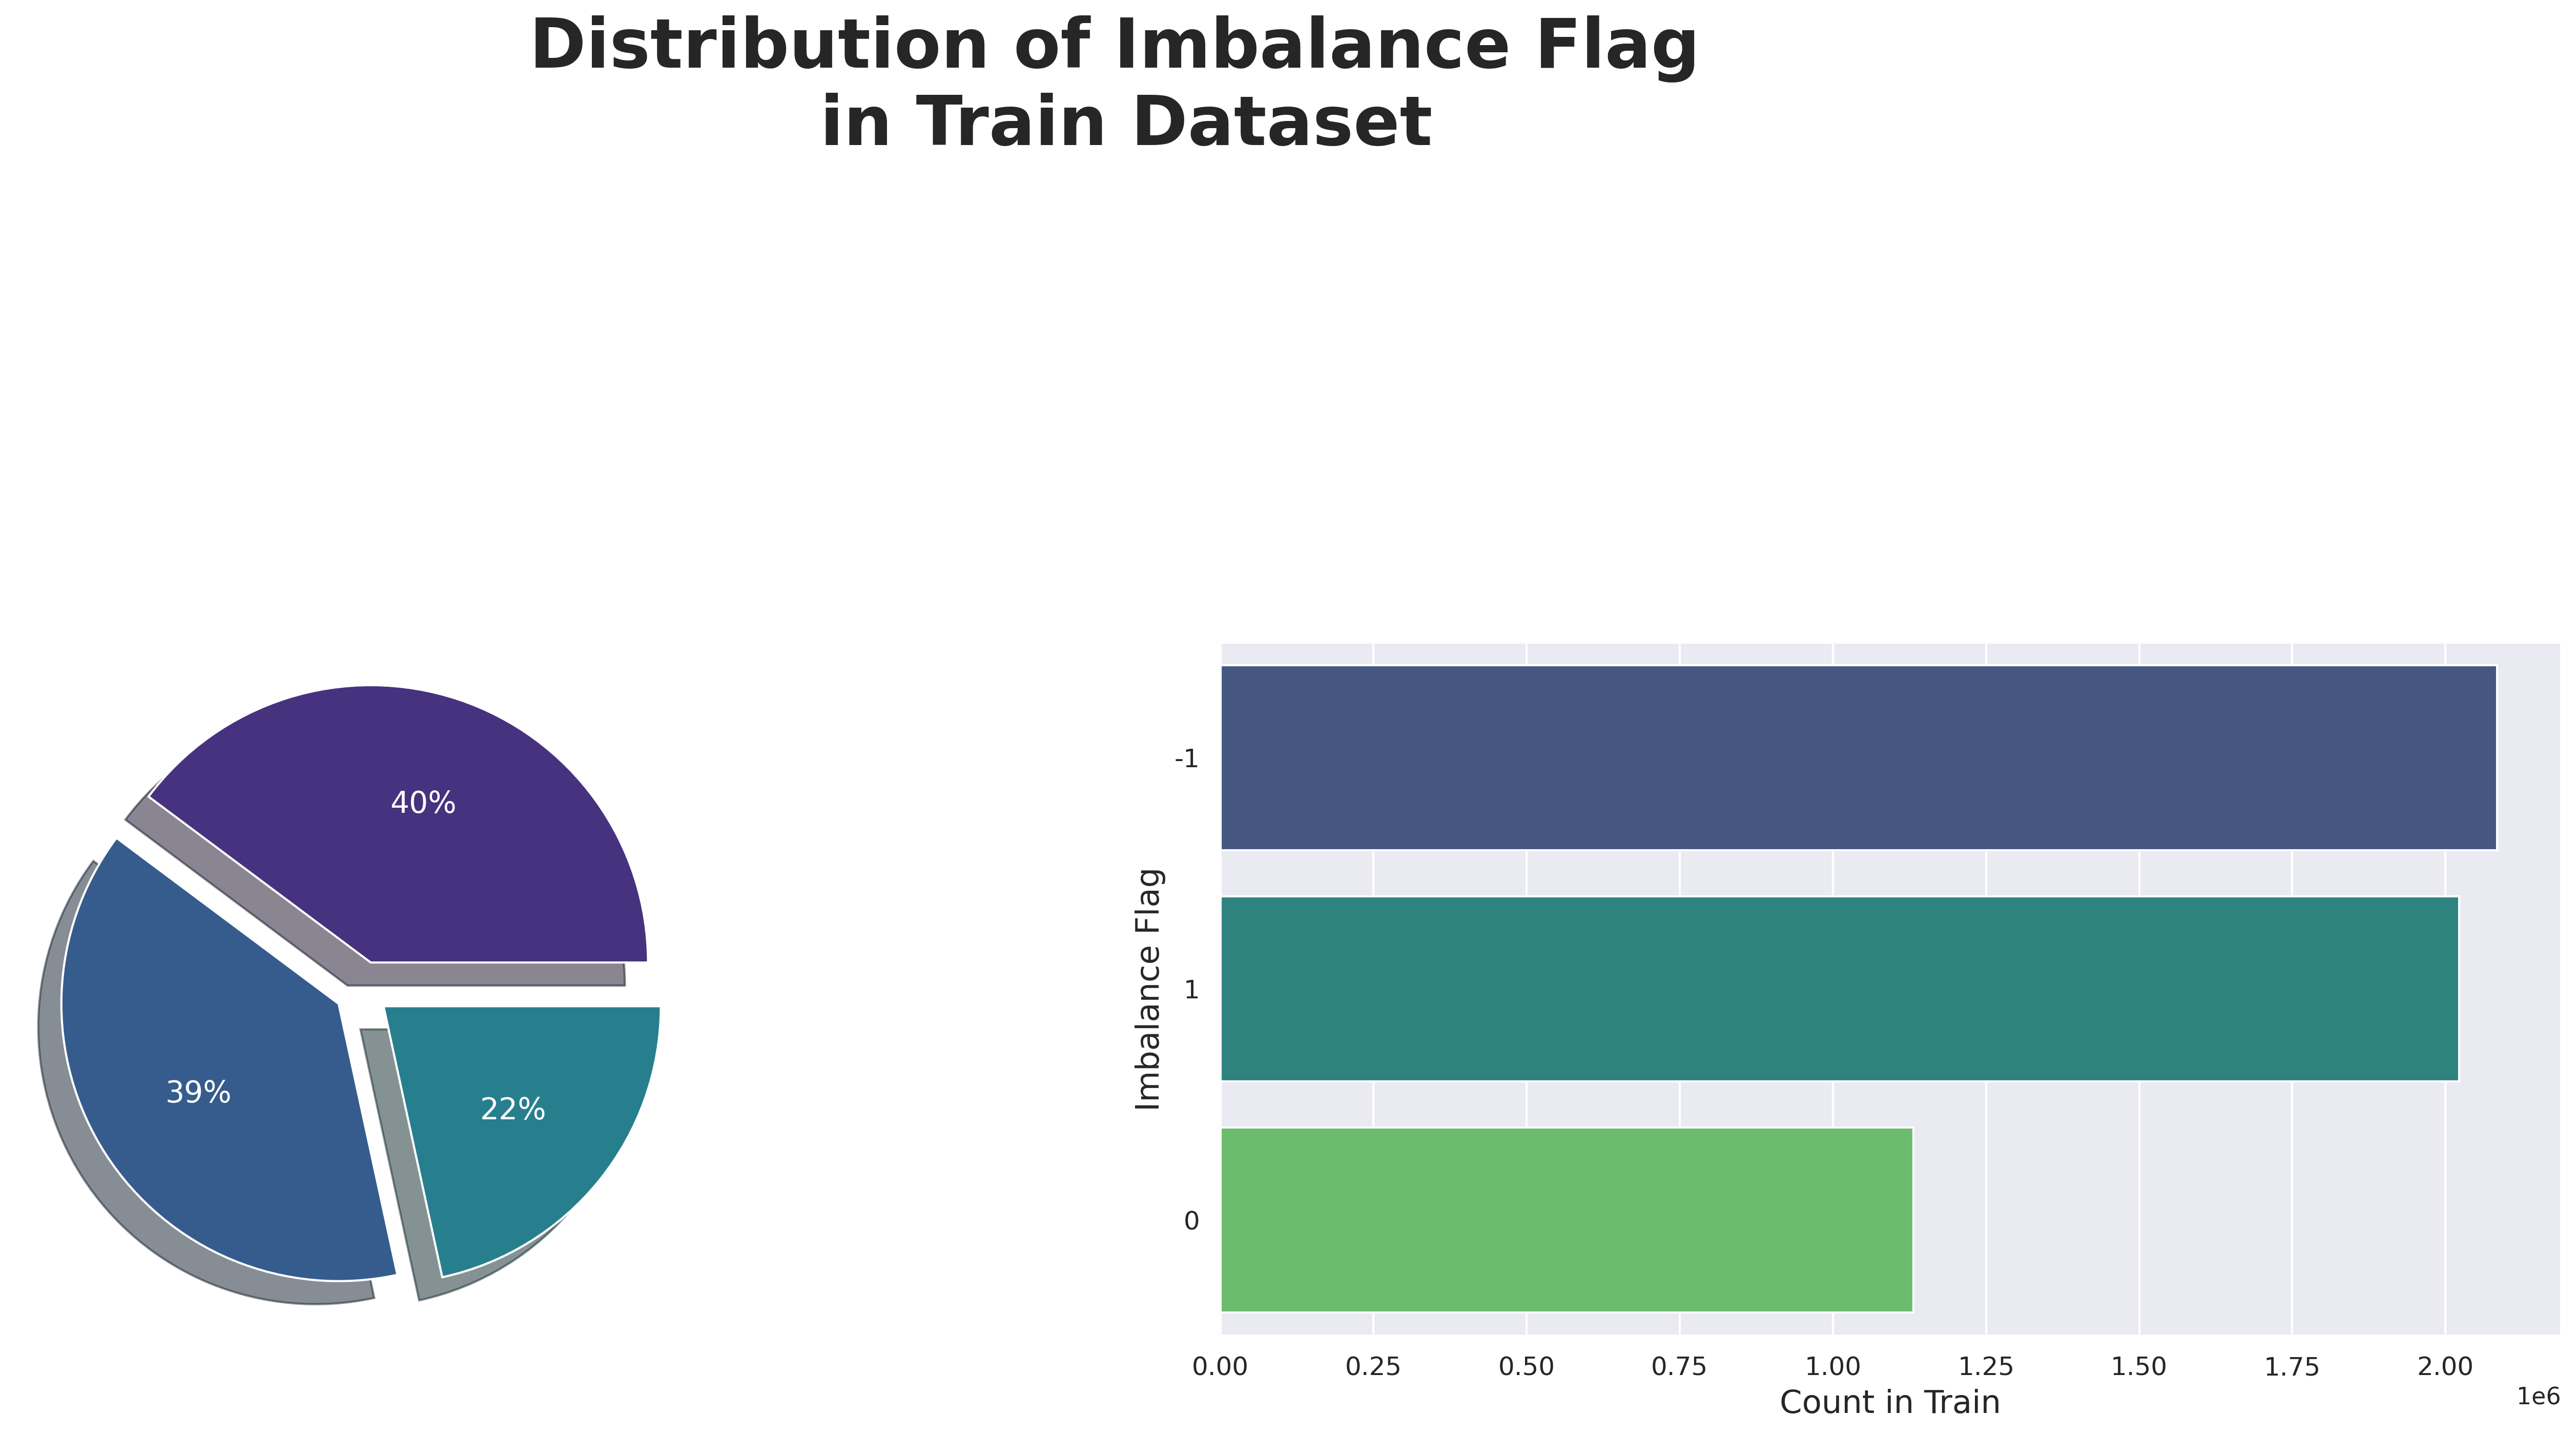

In [14]:
fig, axs = plt.subplots(1, 2, figsize = (20,10), dpi = 300)
axs = axs.flatten()

axs[0].pie(
    train['imbalance_buy_sell_flag'].value_counts(),
    shadow = True,
    explode = [.1 for i in range(train['imbalance_buy_sell_flag'].nunique())],
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = train, y = 'imbalance_buy_sell_flag', ax = axs[1], palette = 'viridis', order = train['imbalance_buy_sell_flag'].value_counts().index)
axs[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
axs[1].set_xlabel("Count in Train", fontsize = 15)
axs[1].set_ylabel("Imbalance Flag", fontsize = 15)
plt.xticks(fontsize = 12)

fig.suptitle("Distribution of Imbalance Flag \n in Train Dataset \n\n\n\n", fontsize = 32, fontweight='bold')
plt.tight_layout(pad = 4)

#### Target Distribution 

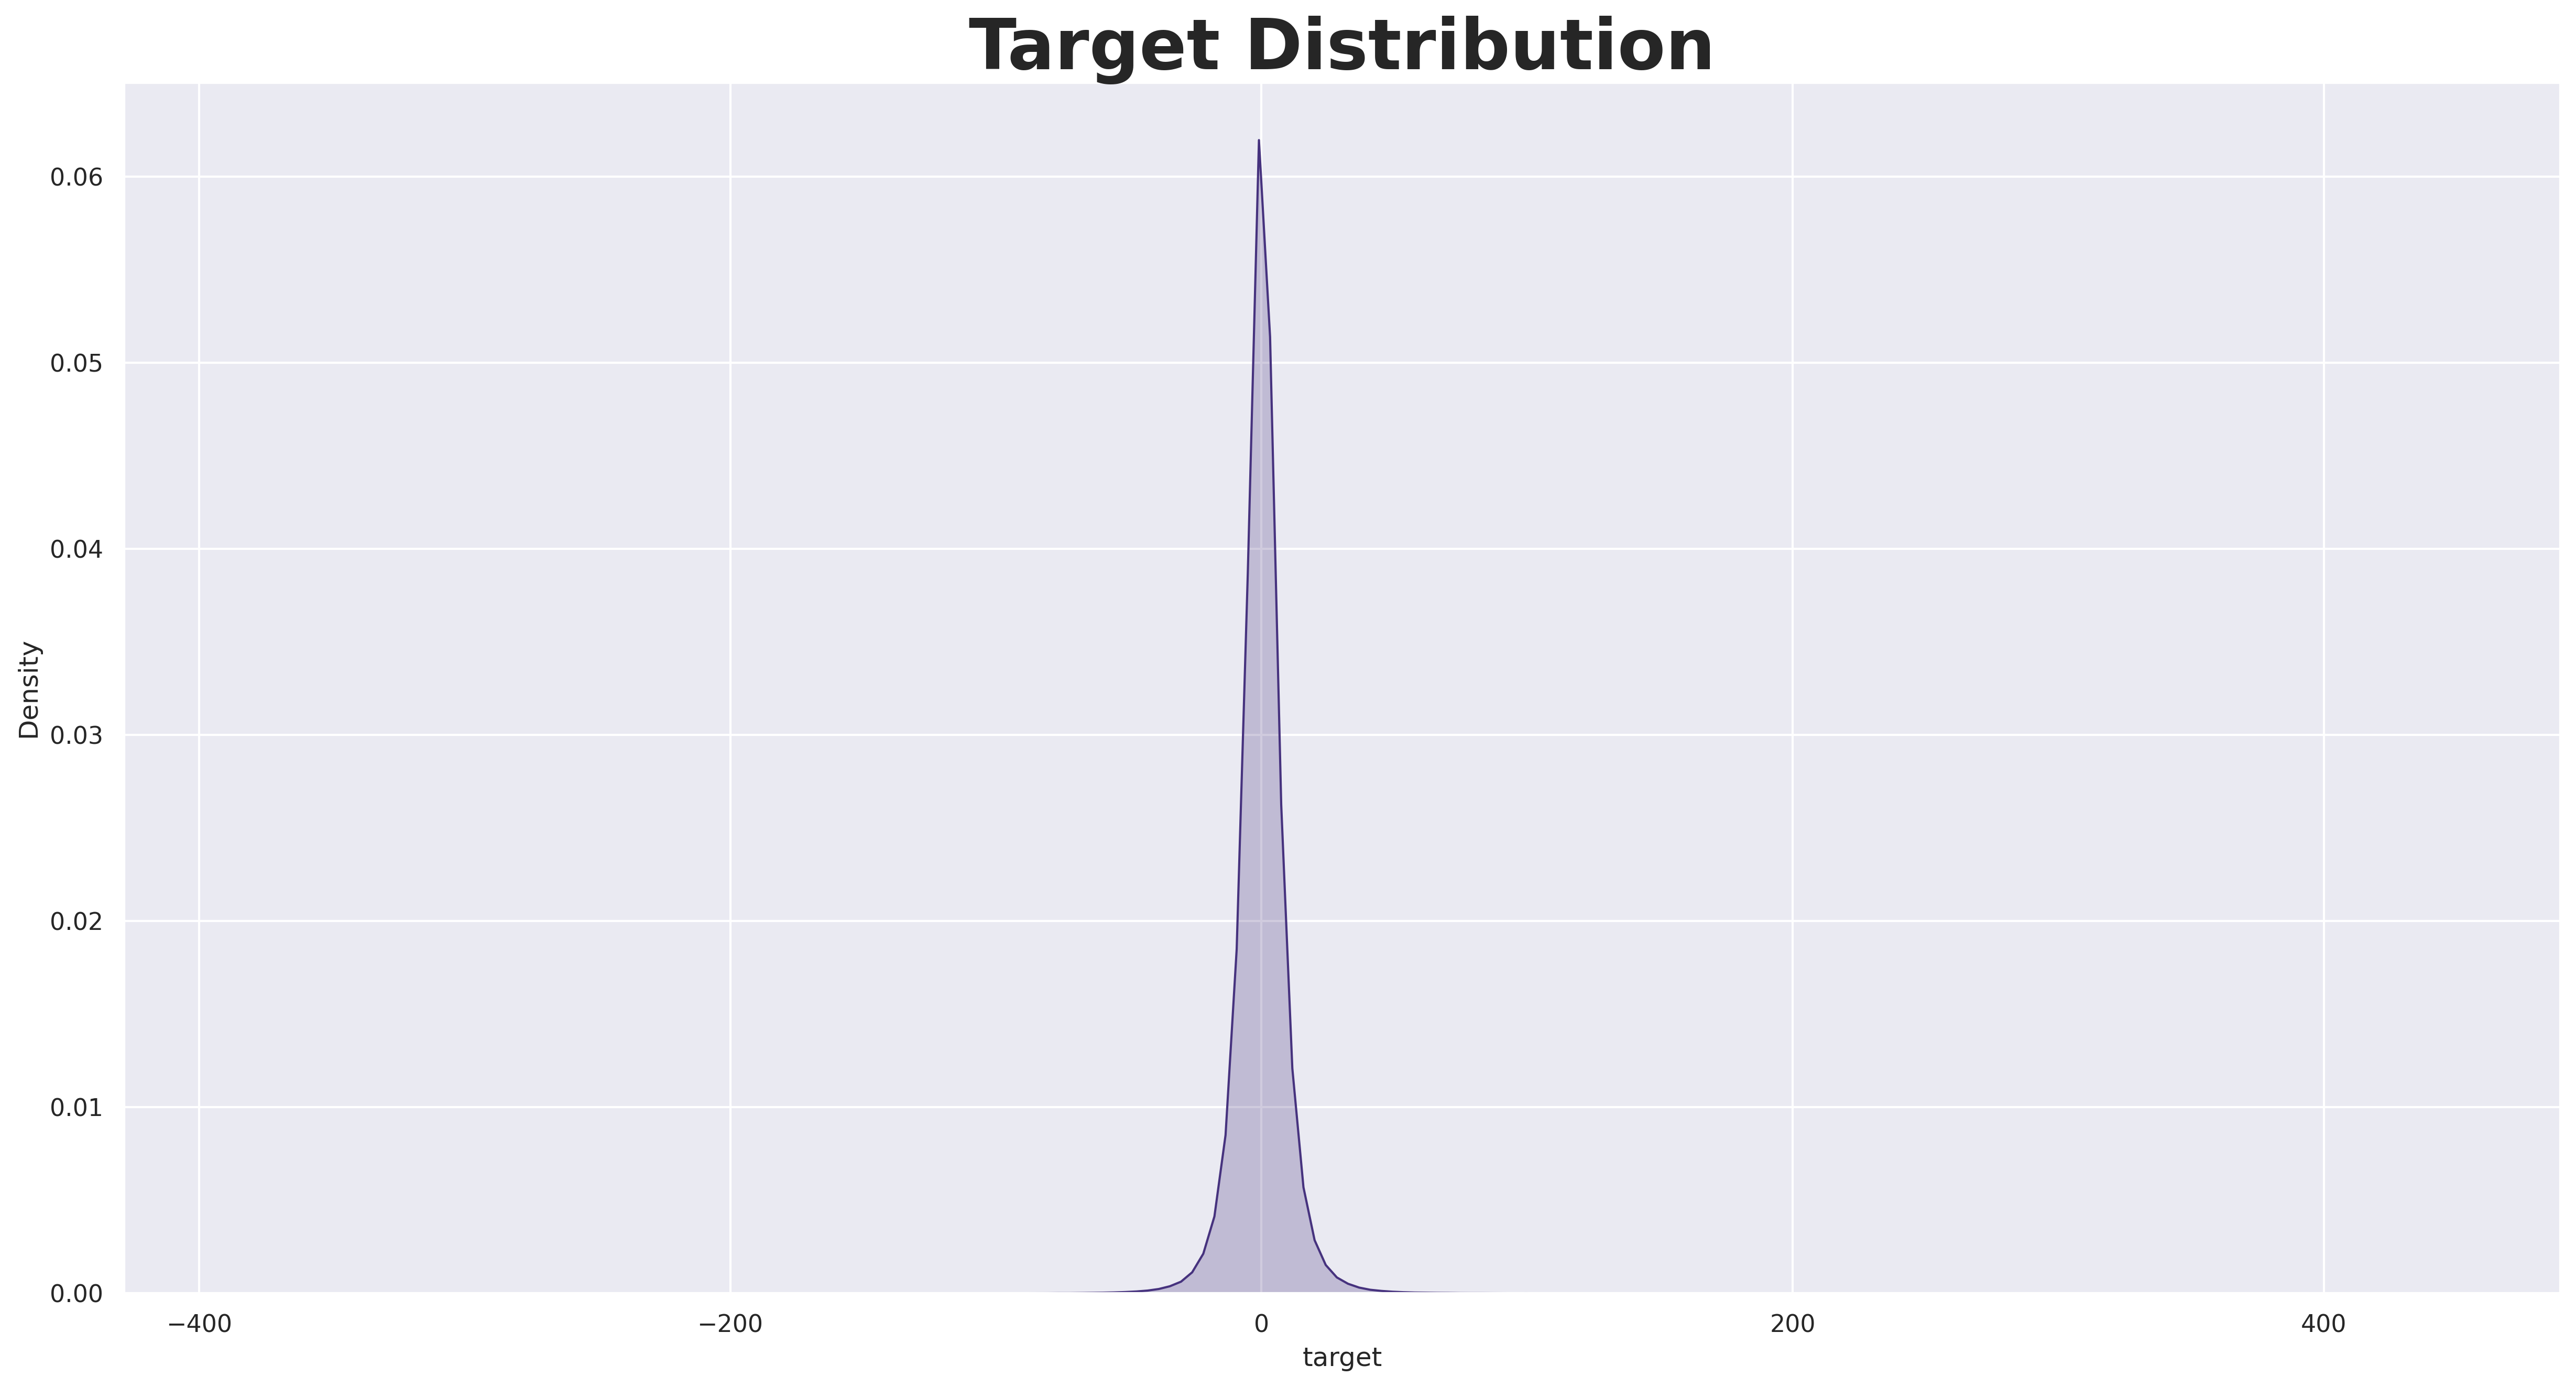

In [15]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.kdeplot(train.target , fill = True)

plt.title("Target Distribution", weight = 'bold', fontsize = 32)
plt.show()

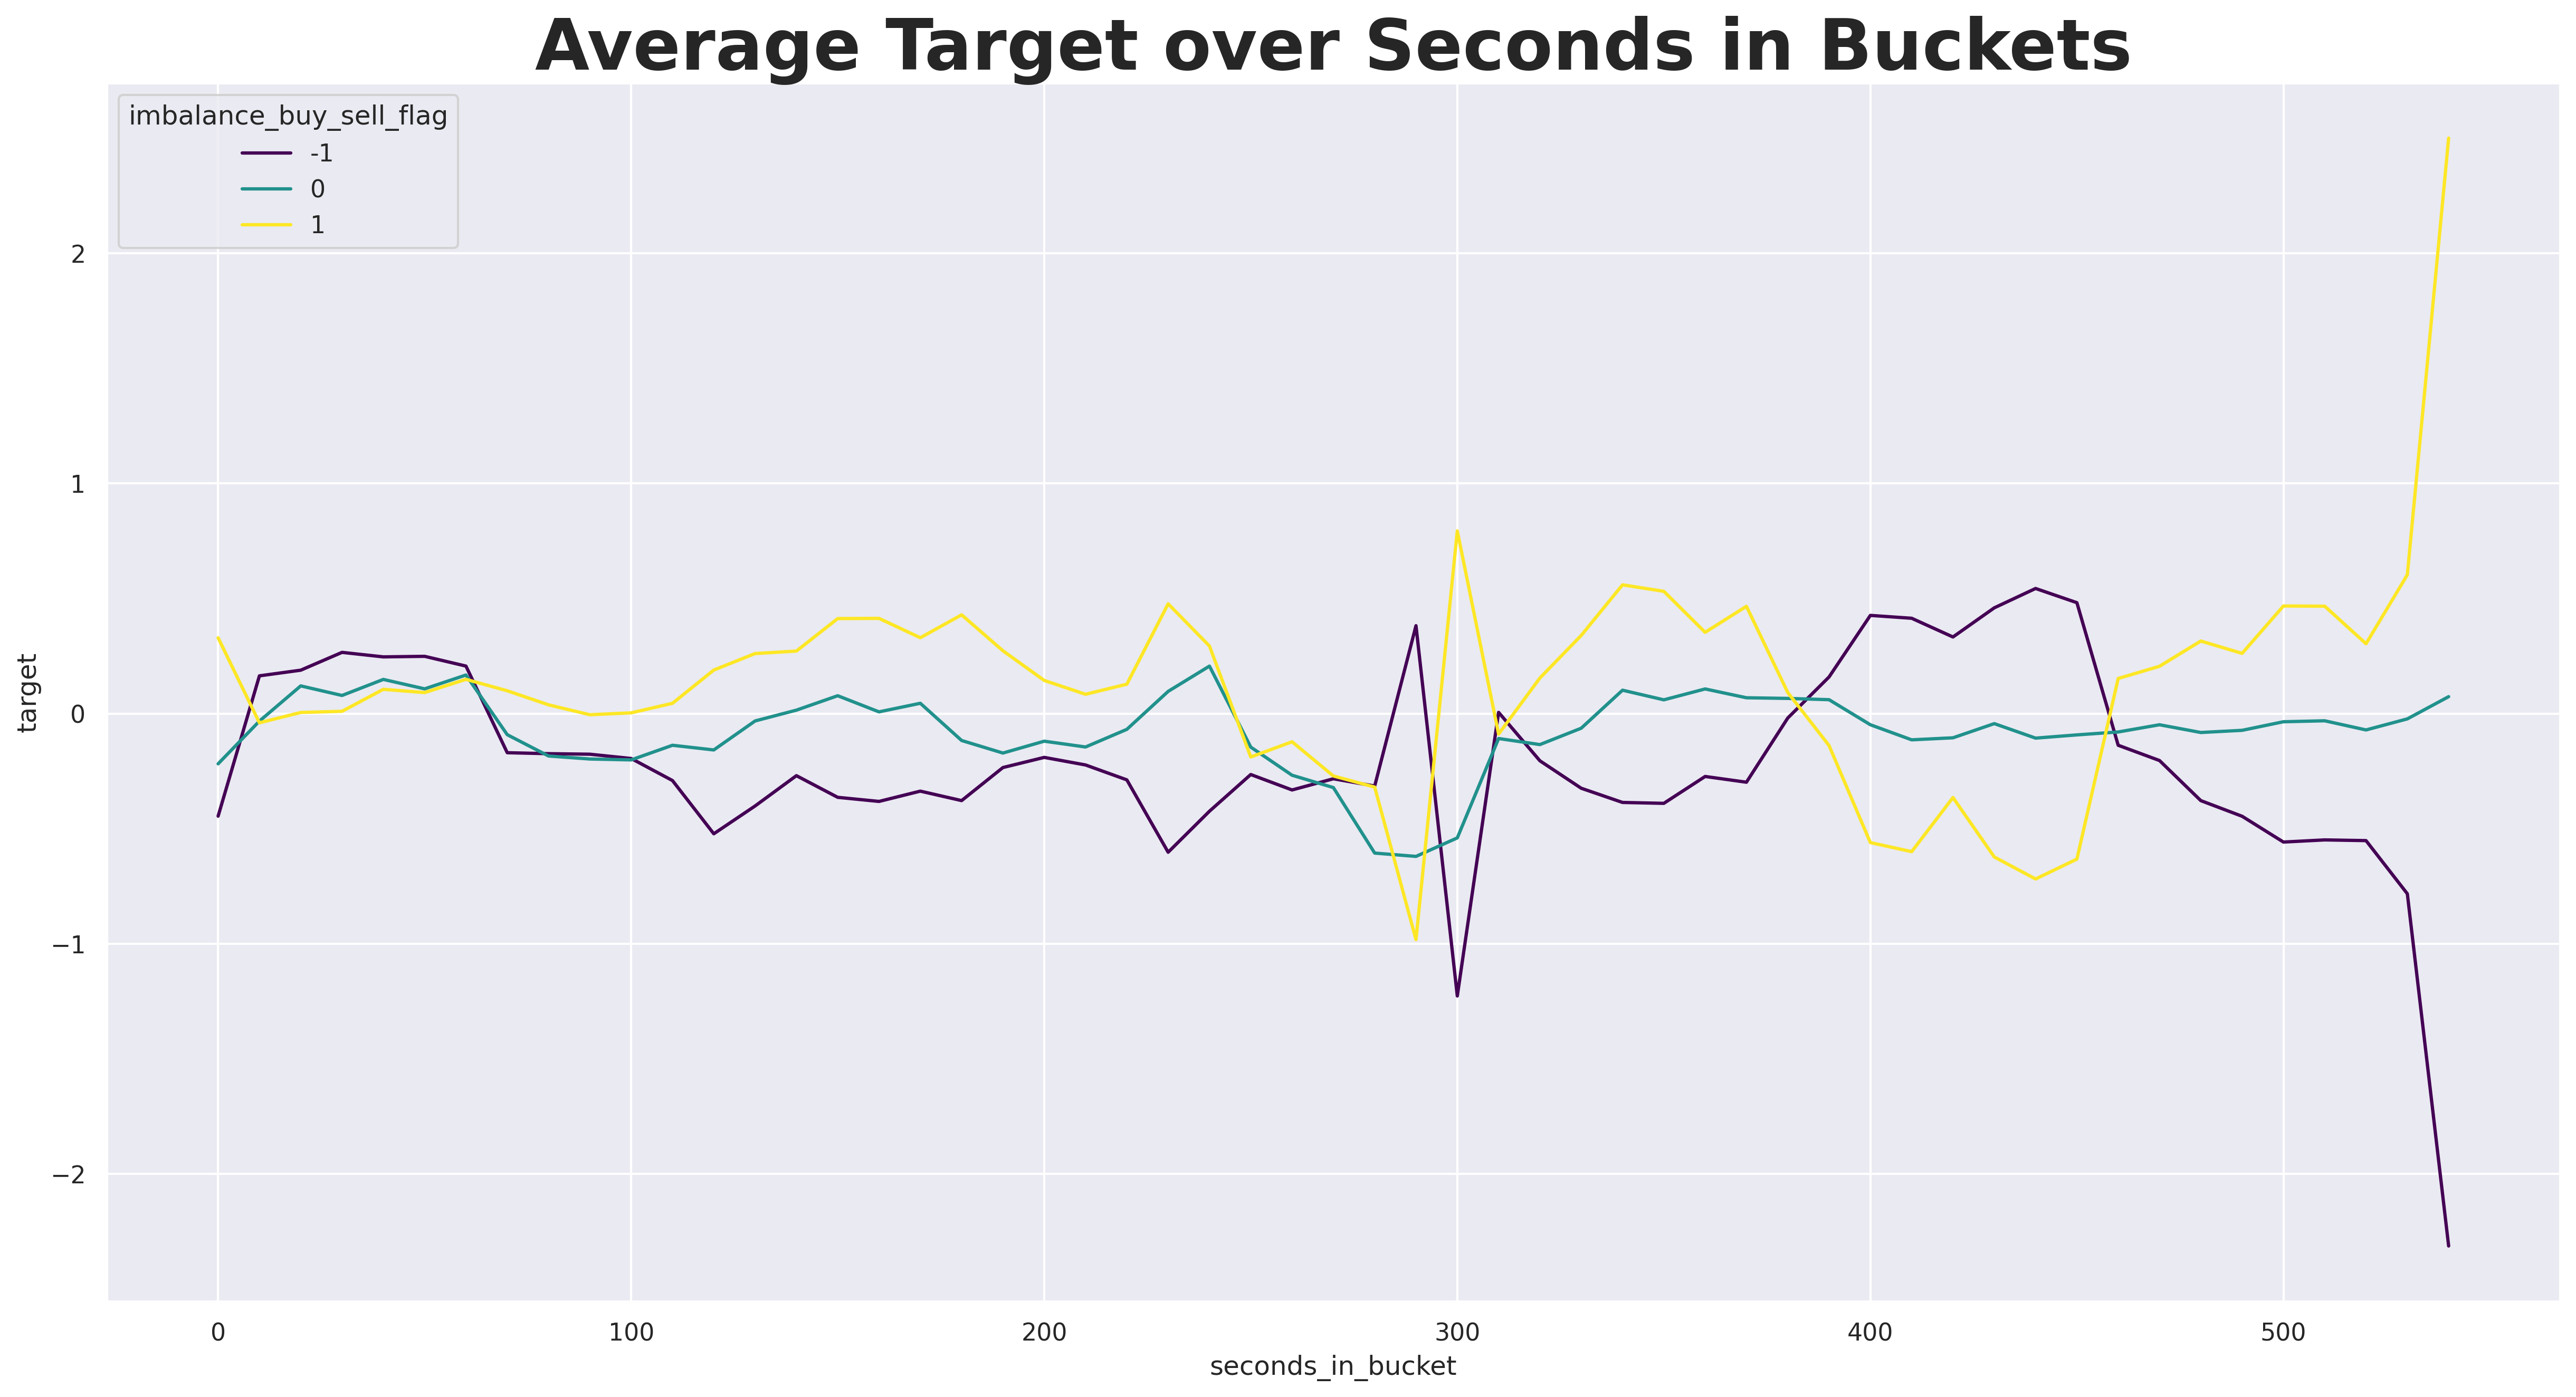

In [17]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train, x = 'seconds_in_bucket', y = 'target', hue = 'imbalance_buy_sell_flag', errorbar = None, palette = 'viridis')

plt.title("Average Target over Seconds in Buckets", weight = 'bold', fontsize = 32)
plt.show()

Buy and Sell go opposite directions while imbalance flag stay in the middle 


### Preparation

Preparing data for training ML models. Will use `Time Series Split` for cross validation 

In [21]:
X = train[~train.target.isna()]
y = X.pop('target')

seed = 42
tss = TimeSeriesSplit(10)

os.environ['PYTHONHASHSEED'] = '42'
tf.keras.utils.set_random_seed(seed)

#### Feature Engineering 

In [34]:
def imbalance_calculator(x):
    
    features = ['seconds_in_bucket', 'imbalance_buy_sell_flag', 'imbalance_size', 'matched_size',
               'bid_size', 'matched_size', 'bid_size', 'ask_size', 'reference_price', 'far_price', 'near_price',
               'ask_price', 'bid_price', 'wap', 'imb_s1', 'imb_s2']
    
    x_copy = x.copy()
    
    x_copy['imb_s1'] = x.eval('(bid_size - ask_size) / (bid_size + ask_size)')
    x_copy['imb_s2'] = x.eval('(imbalance_size - matched_size) / (matched_size + imbalance_size)')
    
    
    prices = ['reference_price', 'far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    
    for i, a in enumerate(prices):
        for j,b in enumerate(prices):
            if i > j :
                x_copy[f'{a}_{b}_imb'] = x.eval(f'({a} - {b}) / ({a} + {b})')
                features.append(f'{a}_{b}_imb')
                
    for i, a in enumerate(prices):
        for j, b in enumerate(prices):
            for k, c in enumerate(prices):
                if i > j and j > k:
                    max_ = x[[a,b,c]].max(axis = 1)
                    min_ = x[[a,b,c]].min(axis = 1)
                    mid_ = x[[a,b,c]].sum(axis = 1) - min_ - max_
                    
                    x_copy[f'{a}_{b}_{c}_imb2'] = (max_ - mid_)/(mid_ - min_)
                    features.append(f"{a}_{b}_{c}_imb2")
    
    return x_copy[features]

ImbalanceCalculator = FunctionTransformer(imbalance_calculator)

### Cross Validation 

LightGBM for modeling since many missing values may have to impute or use model that can implicitly take care of it -> XGBoost, LightGBM, and CatBoost. Using GPU to inc speed due to large size of the data set. 
Note CatBoost's MAE loss function can't be optimized with GPU.

In [24]:
def cross_val_score(estimator, cv = tss, label = ''):
    
    X = train[~train.target.isna()]
    y = X.pop('target')
    
    # Initiate prediction arrays and score lists 
    val_predictions = np.zeros((len(X)))
    
    train_scores, val_scores = [], []
    
    # training model, predicting prognosis probability, and evaluating metrics 
    for fold, (train_idx, val_idx) in enumerate(cv.split(X,y)):
        
        model = clone(estimator)
        
        # define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        # define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        # train model
        model.fit(X_train, y_train)
        
        # make predictions 
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        val_predictions[val_idx] += val_preds
        
        # evaluate model for a fold
        train_score = mean_absolute_error(y_train, train_preds)
        val_score = mean_absolute_error(y_val, val_preds)
        
        # append model score for a fold to list 
        train_scores.append(train_score)
        val_scores.append(val_score)
        
        print(f"Val Score: {np.mean(val_scores):.5f} | Train Score: {np.mean(train_scores)} | {label}")
        
        return val_scores, val_predictions

Placing feature engineering in a pipeline to prevent leakage during cross-val. 

In [ ]:
models = [
    ("XGBoost", XGBRegressor(random_state = seed, objective = 'reg:absoluteerror', tree_method = 'gpu_hist')),
    ("LightGBM", LGBMRegressor(random_state = seed, objective = 'mae', device_type = 'gpu')),
    ("CatBoost", CatBoostRegressor(random_state = seed, objective = 'MAE', verbose = 0))
]

for (label, model) in models:
    _ = cross_val_score(
    make_pipeline(
        ImbalanceCalculator,
        model
    ),
    label = label
    )